In [114]:
#%pip  install litellm
%load_ext autoreload
%autoreload 2

<module 'langgraph.version' from '/Users/simop/miniconda3/lib/python3.11/site-packages/langgraph/version.py'>
DEFAULT_DATA_PATH: /Users/simop/Documents/DataAgent/data/Store_Sales_Price_Elasticity_Promotions_Data.parquet
The file exists
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
# Optional: ensure deps (uncomment if needed)
# %pip install -q langgraph langchain-ollama duckdb pandas pyarrow matplotlib langchain-ollama

from Agent.data_agent import SalesDataAgent

# Initialize the agent (uses default data path: data/Store_Sales_Price_Elasticity_Promotions_Data.parquet)
agent = SalesDataAgent(
    model="llama3.2:3b",       # requires Ollama running locally with this model pulled
    temperature=0.1,
    max_tokens=2000,
    streaming=True
)


In [116]:
agent.check_model()

Server is running locally
Ollama is running locally


True

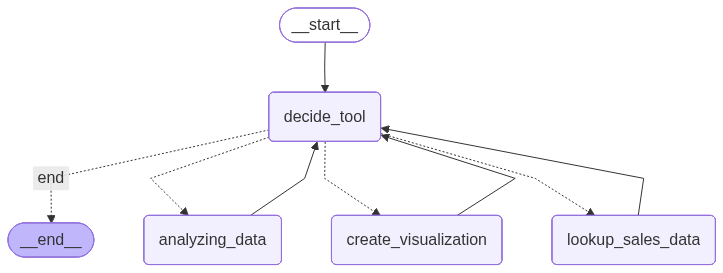

''

In [117]:
agent.draw_graph()

In [118]:
from Agent.data_agent import SalesDataAgent

agent = SalesDataAgent(
    enable_tracing=True,
    phoenix_endpoint="http://localhost:6006/v1/traces",
    project_name="evaluating-agent",
    model="llama3.2:3b"
)
#ret = agent.run("What was the most popular product SKU?")
#print(ret.get("answer"))

Overriding of current TracerProvider is not allowed
Attempting to instrument while already instrumented


🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: evaluating-agent
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: http://localhost:6006/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [119]:
import json
import os

import csv
from typing import Dict, List, Tuple

In [120]:
def text_to_csv(text: str) -> List[List[str]]:
    """Convert text table to CSV rows.
    
    Handles both space-separated and pipe-separated formats.
    """
    lines = [line.strip() for line in text.strip().split('\n') if line.strip()]
    if not lines:
        return []
    
    rows = []
    for line in lines:
        # Try splitting by multiple spaces first
        if '  ' in line:
            parts = [p.strip() for p in line.split() if p.strip()]
        # Try pipe separator
        elif '|' in line:
            parts = [p.strip() for p in line.split('|') if p.strip()]
        # Fallback to comma
        else:
            parts = [p.strip() for p in line.split(',') if p.strip()]
        
        if parts:
            rows.append(parts)
    
    return rows

def save_csv(rows: List[List[str]], filepath: str):
    """Save rows to CSV file."""
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    with open(filepath, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerows(rows)


In [121]:
PREFIX = 'claude'
DATASET_FILE_PATH = f"evaluation/{PREFIX}_dataset.json"
if os.path.exists(DATASET_FILE_PATH):
    with open(DATASET_FILE_PATH, 'r') as f:
        dataset = json.load(f)

for i in range(len(dataset)):
    if (dataset[i].get('gen_sql') and dataset[i].get('gen_data')):
        print(f'\nSkipping question {i+1}/{len(dataset)} as generated results were already added.')
        continue
    print(f"------- Question {i+1}/{len(dataset)} -------")

    ret = agent.run(dataset[i]['prompt'], only_lookup=True)
    dataset[i]['gen_sql']=ret['sql_query']
    dataset[i]['gen_data']=ret['data']
    csv_path = f"evaluation/csv_queries/{PREFIX}_{i}_gen.csv"
    result_rows = text_to_csv(ret['data'])
    save_csv(result_rows, csv_path)
    dataset[i]["gen_csv_path"]=csv_path

with open(DATASET_FILE_PATH, 'w') as f:
    json.dump(dataset, f, indent=2)

------- Question 1/10 -------
Checking the model can run locally
Server is running locally
Ollama is running locally
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT Store_Number, sum(Qty_Sold), sum(Total_Sale_Value) 
FROM sales 
WHERE CAST(Sold_Date AS VARCHAR) LIKE '%2023%' AND On_Promo = 1
GROUP BY Store_Number
------- Question 2/10 -------
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT Store_Number, SKU_Coded, Product_Class_Code, SUM(Total_Sale_Value) AS total 
FROM sales 
WHERE CAST(Sold_Date AS VARCHAR) LIKE '%2022%' AND On_Promo = 1
GROUP BY Store_Number, SKU_Coded, Product_Class_Code
------- Question 3/10 -------
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT Store_Number, SKU_Coded, Product_Class_Code, Sold_Date, SUM(Qty_Sold) AS total FROM sales WHERE CAST(Sold_Date AS VARCHAR) LIKE '%2023%' GROUP BY Store_Number, SKU_Coded, Product_Class_Code, Sold_Date
------- Question 4/10 -------
[Agent] Running only lookup_sale

In [122]:
from csv_evaluator import compare_csv

<module 'langgraph.version' from '/Users/simop/miniconda3/lib/python3.11/site-packages/langgraph/version.py'>
DEFAULT_DATA_PATH: /Users/simop/Documents/DataAgent/data/Store_Sales_Price_Elasticity_Promotions_Data.parquet
The file exists


In [124]:
def best_of_n(agent, prompt: str, expected_csv: str = None, n: int=3) -> Dict:
    temperatures = [i/(n+1) for i in range(1,n+1)]
    #temperatures = [i/(n-1) for i in range(0,n)] #Using extremes
    max_score=-1
    original_temp = agent.llm.temperature
    for i,temp in enumerate(temperatures):
        print(f"\n--- Attempt {i+1}/{n} (temperature={temp:.2f}) ---")
        agent.llm.temperature = temp
        try:
            ret = agent.run(prompt, only_lookup=True)
            csv_path = expected_csv.replace('_gt.csv', f'_gen_temp_{temp:.2f}.csv')
            result_rows = text_to_csv(ret['data'])
            save_csv(result_rows, csv_path)
            columns_names_iou, rows_iou, columns_iou, data_iou = compare_csv(expected_csv, csv_path)
            print(f"Columns Names IoU: {columns_names_iou:.2f} -- Rows IoU: {rows_iou:.2f} -- Columns IoU: {columns_iou:.2f} -- Data IoU: {data_iou:.2f}")
            score = (rows_iou + columns_iou + data_iou)/3
            print(f"Score: {score:.2f}")
            if score>max_score:
                best_result = {
                    'result': ret,
                    'score': score,
                    'temperature': temp,
                    'attempt': i + 1
                }
        except Exception as e:
            print(f"Error in attempt {i+1}: {e}") 

    if max_score == -1:
        return []
    agent.llm.temperature = original_temp
    return best_result

In [44]:
PREFIX = 'claude'
DATASET_FILE_PATH = f"evaluation/{PREFIX}_dataset.json"
if os.path.exists(DATASET_FILE_PATH):
    with open(DATASET_FILE_PATH, 'r') as f:
        dataset = json.load(f)
i=4
data = dataset[i]
ret = best_of_n(
    agent, 
    data['prompt'],
    expected_csv=data['gt_csv_path'],  
    gen_csv_path  = data['gen_csv_path'],
    n=5  # Try with 3, 4, or 5 different temperatures
)


--- Attempt 1/5 (temperature=0.16666666666666666) ---
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT SKU_Coded, SUM(Total_Sale_Value) AS total_revenue, SUM(Qty_Sold) AS total_units, 
       (SUM(Total_Sale_Value) / SUM(Qty_Sold)) * 100000 AS avg_unit_price
FROM sales
WHERE CAST(Sold_Date AS VARCHAR) LIKE '%2023%'
GROUP BY SKU_Coded
ORDER BY total_revenue DESC
LIMIT 10
Rows IoU: 0.00 -- Columns IoU: 1.00
Score (IoU): 0.00

--- Attempt 2/5 (temperature=0.3333333333333333) ---
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT SKU_Coded, SUM(Total_Sale_Value) as total_revenue, SUM(Qty_Sold) as total_units, (SUM(Total_Sale_Value) * 100 / SUM(Qty_Sold)) as avg_unit_price FROM sales WHERE CAST(Sold_Date AS VARCHAR) LIKE '%2023%' GROUP BY SKU_Coded ORDER BY total_revenue DESC LIMIT 10
Rows IoU: 0.00 -- Columns IoU: 1.00
Score (IoU): 0.00

--- Attempt 3/5 (temperature=0.5) ---
[Agent] Running only lookup_sales_data
Generated SQL Query:
 SELECT SKU_Coded, 